In [1]:
import numpy as np
from PIL import Image

import tensorflow as tf

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image as keras_image

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [2]:
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
backend.set_session(tf.Session(config=config))

In [4]:
content_path = "./data/input/input9.jpg"
style_path = "./data/style/style5.jpg"

In [5]:
# Hyperparams
# Default weight 0.02 Style Weight 4.5
ITERATIONS = 10
CHANNELS = 3
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [6]:
IMAGE_SIZE = 512

img = Image.open(content_path)
# Calculating scale for resizing
long = max(img.size)
scale = IMAGE_SIZE/long
IMAGE_WIDTH = round(img.size[0]*scale)
IMAGE_HEIGHT = round(img.size[1]*scale)

In [7]:
def load_img(path_to_image):
    # Open Image
    img = Image.open(path_to_image)
    # Calculating scale for resizing
    max_dim = IMAGE_SIZE
    long = max(img.size)
    scale = max_dim/long
    # Resize the image
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    # Convert to array
    img = keras_image.img_to_array(img)
    # Broadcast the image array such that it has a batch dimension
    img = np.expand_dims(img, axis = 0)
    return img

In [8]:
def imshow(img, title = None):
    # Remove the batch dimension
    out = np.squeeze(img,axis=0)
    # Normalize for display
    out = out.astype('uint8')
    if title is not None : 
        plt.title(title)
    plt.imshow(out)

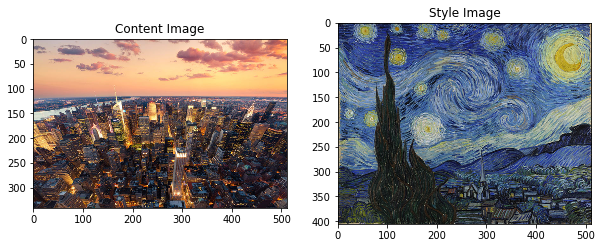

In [9]:
# Pyplot figure with size 10*10
plt.figure(figsize=(10,10))
# Load image
content = load_img(content_path)
style = load_img(style_path)

# Position 1
plt.subplot(1,2,1) 
imshow(content, 'Content Image')

# Position 2
plt.subplot(1,2,2) 
imshow(style, 'Style Image')

plt.show()

In [10]:
def load_and_process_img(path_to_image):
    # Open Image
    img = Image.open(path_to_image)
    # Resize the image
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.ANTIALIAS)
    # Normalization and Reshaping to BGR
    img = keras_image.img_to_array(img, dtype = 'float32')
    img = np.expand_dims(img,axis = 0)
    img[:,:,:,0] -= IMAGENET_MEAN_RGB_VALUES[2]
    img[:,:,:,1] -= IMAGENET_MEAN_RGB_VALUES[1]
    img[:,:,:,2] -= IMAGENET_MEAN_RGB_VALUES[0]
    img = img[:,:,:,::-1]
    return img

In [11]:
input_image_array = load_and_process_img(content_path)
style_image_array = load_and_process_img(style_path)

In [12]:
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1,IMAGE_HEIGHT,IMAGE_WIDTH,3))

In [13]:
input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)

In [14]:
model = VGG16(input_tensor = input_tensor, include_top = False)

In [15]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

#### For content extraction

In [16]:
content_layer = "block2_conv2"

In [17]:
layer_features = layers[content_layer]
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]

##### For Minimizing the content loss between input image and output image

In [18]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

In [19]:
loss = backend.variable(0.)
loss = loss + CONTENT_WEIGHT * content_loss(content_image_features,combination_features)

In [20]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [21]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

In [22]:
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

In [23]:
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

##### Smooth the image and prevent denoising

In [24]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

In [25]:
loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

###### For Optimization

In [26]:
class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

In [27]:
evaluator = Evaluator()

In [28]:
def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

In [29]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

In [30]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

In [31]:
results = []
for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    results.append(x)

Iteration 0 completed with loss 35152347136
Iteration 1 completed with loss 14895222784
Iteration 2 completed with loss 10097567744
Iteration 3 completed with loss 8606572544
Iteration 4 completed with loss 8109809664
Iteration 5 completed with loss 7860036608
Iteration 6 completed with loss 7701649408
Iteration 7 completed with loss 7593088512
Iteration 8 completed with loss 7507963904
Iteration 9 completed with loss 7439380992


In [32]:
def deprocessing_image(input_image):
    image = input_image.copy()
    image = image.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    image = image[:, :, ::-1]
    image[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
    image[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
    image[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
    image = np.clip(image, 0, 255).astype("uint8")
    return image

In [33]:
output_image = deprocessing_image(x)

In [34]:
output_image = keras_image.array_to_img(output_image)

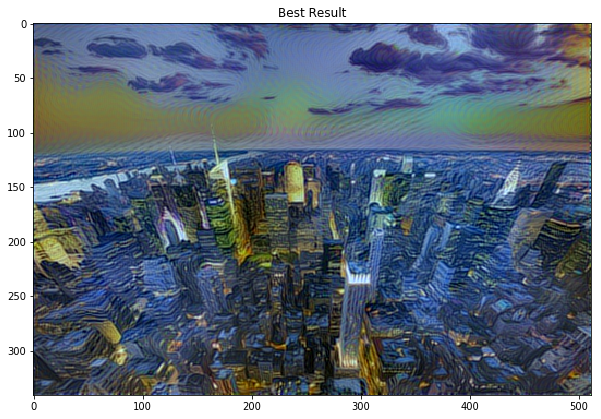

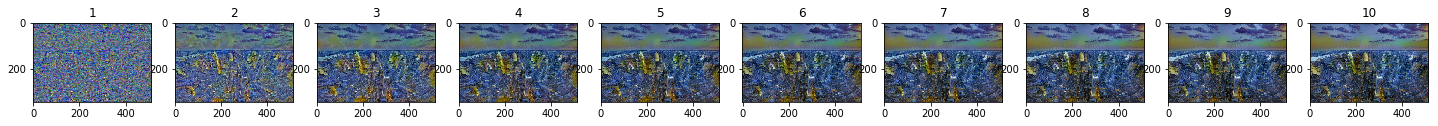

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.title('Best Result')

import math

n_col = 10
n_row = math.ceil((len(results)/10)+0.5)

plt.figure(figsize=(25,25))
for idx , result in enumerate(results):
    result_image = deprocessing_image(result)
    result_image = keras_image.array_to_img(result_image)
    plt.subplot(n_row,n_col,idx+1)
    plt.imshow(result_image)
    plt.title(idx+1)
    
plt.show()

In [36]:
def show_results(output, content, style):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(content,'Original Image')
    plt.subplot(1, 2, 2)
    imshow(style,'Style Image')
    plt.figure(figsize=(10, 10))
    plt.imshow(output)
    plt.title('Output Image')
    plt.show()

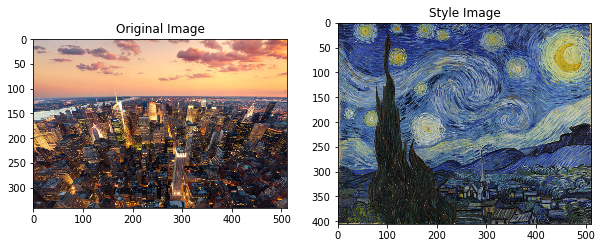

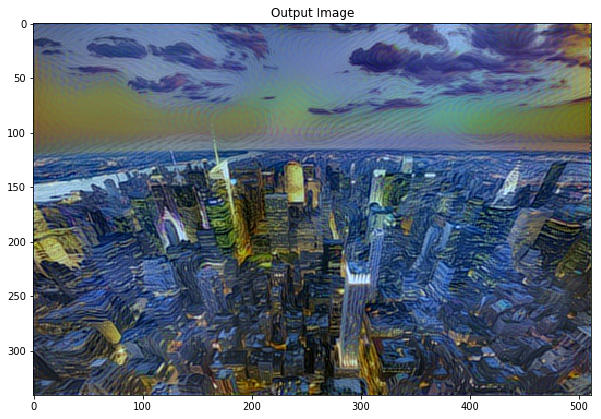

In [37]:
content = load_img(content_path)
style = load_img(style_path)
show_results(output_image,content,style)